In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


## IMPORT DATA

In [184]:
#read in data frame (adjust as needed)
df=pd.read_csv('df_merged.csv')
df.shape

/var/folders/kn/v0dr_8xn1qj15xgwlhdyfzph0000gn/T/ipykernel_4523/155646178.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('df_merged.csv')


,Unnamed: 0,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,...,hour,day,day_of_week,week_of_year,month,year,minute_after_first,hour_after_first,day_after_first,time
0,0,condition_1,11.0,2,35-39,2.0,2.0,2.0,6-10,1.0,...,12,7,2,19,5,2003,1.0,0.0,0.0,02-720
1,1,condition_1,11.0,2,35-39,2.0,2.0,2.0,6-10,1.0,...,12,7,2,19,5,2003,2.0,0.0,0.0,02-721
2,2,condition_1,11.0,2,35-39,2.0,2.0,2.0,6-10,1.0,...,12,7,2,19,5,2003,3.0,0.0,0.0,02-722
3,3,condition_1,11.0,2,35-39,2.0,2.0,2.0,6-10,1.0,...,12,7,2,19,5,2003,4.0,0.0,0.0,02-723
4,4,condition_1,11.0,2,35-39,2.0,2.0,2.0,6-10,1.0,...,12,7,2,19,5,2003,5.0,0.0,0.0,02-724


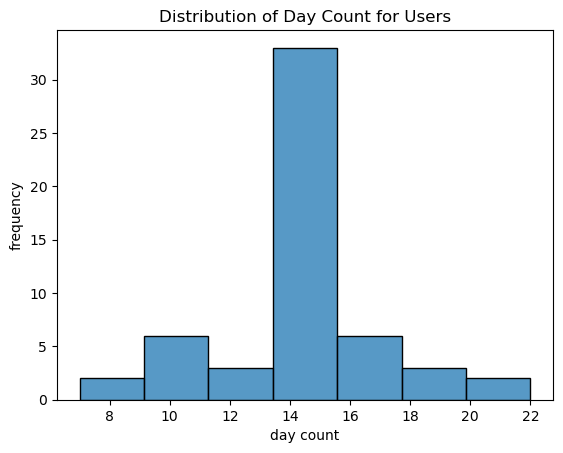

In [165]:
#Distribution of Day Count for Users

sns.histplot(df.groupby(['number','day']).count().reset_index().groupby('number').count().reset_index()['day'])
plt.xlabel('day count')
plt.ylabel('frequency')
plt.title('Distribution of Day Count for Users')
plt.show()

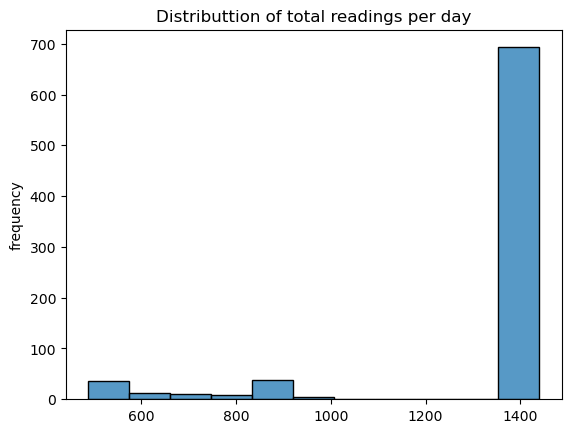

In [166]:
#Distributtion of total readings per day
day_freq=df.groupby(['number','day']).count().days
y=day_freq.values
plt.ylabel('frequency')
plt.title('Distributtion of total readings per day')
sns.histplot(y)
plt.show()

## FUNCTIONS

In [167]:
#if active, will remove days that do not have 1440 recordings per day
def remove_partial_days(filtered_df):
    
    #group by to find days and months for each person that does not contain 1440 recordings
    temp_df=df.groupby(['number','month','day']).count().reset_index()
    temp_df=temp_df.loc[temp_df['days']!=1440]

    #create an array with array of number, day, and month that do not have 1440 recordings
    to_delete=np.array([temp_df.number.values,temp_df.month.values,temp_df.day.values])

    for i in range(to_delete.shape[1]):
        td_number=to_delete[0][i]
        td_month=to_delete[1][i]
        td_day=to_delete[2][i]

        filtered_df=filtered_df.loc[~((df.number==td_number) & (df.month==td_month) & (df.day==td_day))]
        
    return filtered_df
    

In [168]:
#function creates a dictionary of users and split number of days (starting at end of time-series)
def return_dictionary_of_split_days(temp_df,split):
    #create dictionary of users and their last seven days
    new_group_days={num:(np.array(temp_df.loc[temp_df.number==num].day.unique())[-split:])
                                        for num in temp_df.number.unique()}

    return new_group_days

In [169]:
#filter to keep only rows that match number and day for groupA and assign to new df
def create_new_split(temp_df,splits_dict,suffix):   
    for key,value in splits_dict.items():
        temp_df=temp_df.loc[~((temp_df.number==key) & (~temp_df.day.isin(value)))]
        
    #add a suffix
    temp_df.loc[:,'number']=temp_df.number+suffix
        
    return temp_df

In [170]:
#filter out the newly pulled users and days from df_edit
def remove_users(temp_df,splits_dict):
    for key,value in splits_dict.items():
        temp_df=temp_df.loc[~((temp_df.number==key) & (temp_df.day.isin(value)))]

    return temp_df

## MAIN CODE - Split DF

In [183]:
#----------------------------------------
#SET PARAMETERS for how to SPLIT USERS
#----------------------------------------
split=7 #split users into groups containing this number of days
remove_partial=False #if true, remove days without 1440 active readings

#----------------------------------------
#RUN MAIN CODE to SPLIT USERS
#----------------------------------------

#suffix to append to newly created users (ex: control_1 -> control_1B)
user_suffix = np.array([chr(i) for i in range(ord('a'), ord('z') + 1)])

#remove days without 1440 readings
if (remove_partial==True):
    df_edit=remove_partial_days(df)
else:
    df_edit=df

#Initiate new data frame to split users
df_splits=pd.DataFrame({})

#loop through and create new groups based on user inputed split
i=0
while len(df_edit) != 0:

    #return a dictionary of split # of days for remaining users
    splits_dict=return_dictionary_of_split_days(df_edit,split)
    
    #take new split of users and days and add it to the splits_df
    df_splits=pd.concat([df_splits,create_new_split(df_edit,splits_dict,user_suffix[i])])
    
    #filter out the newly pulled users and days from df_edit
    df_edit=remove_users(df_edit,splits_dict)

    i+=1

#sort new data set
df_splits = df_splits.sort_values(['number', 'date'], ascending=[True, True])

print(f'Number of Users Total: {len(df_splits.number.unique())}')
df_splits.head()

Number of Users Total: 152


,index,Unnamed: 0,number,days,gender,age,afftype,melanch,inpatient,edu,...,hour,day,day_of_week,week_of_year,month,year,minute_after_first,hour_after_first,day_after_first,time
0,167931,215312,condition_10a,9.0,2,45-49,2.0,2.0,2.0,6-10,...,0,4,5,36,9,2004,5221.0,87.0,3.0,05-0
1,167932,215313,condition_10a,9.0,2,45-49,2.0,2.0,2.0,6-10,...,0,4,5,36,9,2004,5222.0,87.0,3.0,05-1
2,167933,215314,condition_10a,9.0,2,45-49,2.0,2.0,2.0,6-10,...,0,4,5,36,9,2004,5223.0,87.0,3.0,05-2
3,167934,215315,condition_10a,9.0,2,45-49,2.0,2.0,2.0,6-10,...,0,4,5,36,9,2004,5224.0,87.0,3.0,05-3
4,167935,215316,condition_10a,9.0,2,45-49,2.0,2.0,2.0,6-10,...,0,4,5,36,9,2004,5225.0,87.0,3.0,05-4


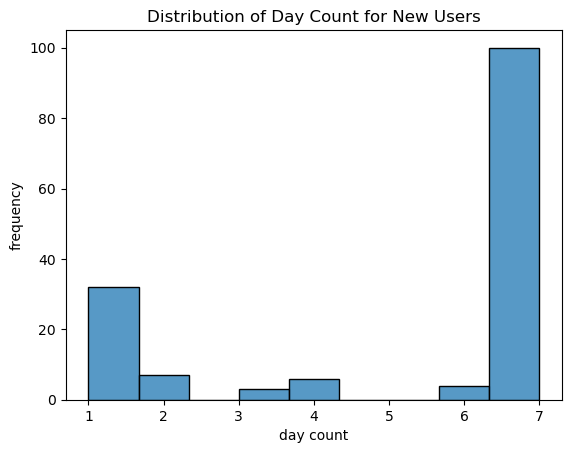

In [172]:
#Distribution of Day Count for New Users

sns.histplot(df_splits.groupby(['number','day']).count().reset_index().groupby('number').count().reset_index()['day'])
plt.xlabel('day count')
plt.ylabel('frequency')
plt.title('Distribution of Day Count for New Users')
plt.show()

In [180]:
#Set number of tolerable missings days for users. 
#Set to 0 if you don't want missing days
missing_days_allowed=0 

#find users with more than the alloted number of missing days
temp_df=df_splits.groupby(['number','day']).count().reset_index().groupby(['number']).count()
users_with_too_few_days=temp_df.loc[temp_df.day<split-missing_days_allowed].reset_index().number

df_splits=df_splits.loc[~df_splits.number.isin(users_with_too_few_days)]

print(f'Number of Users Total: {len(df_splits.number.unique())}')

Number of Users Total: 100


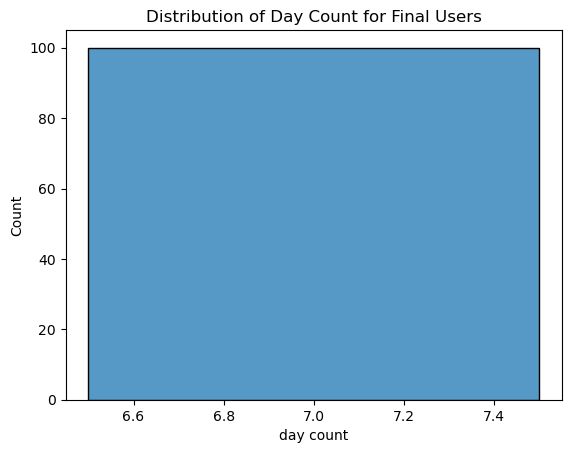

In [176]:
#Distribution of Day Count for Final Users
sns.histplot(df_splits.groupby(['number','day']).count().reset_index().groupby('number').count().reset_index()['day'])
plt.xlabel('day count')
plt.title('Distribution of Day Count for Final Users')
plt.show()

In [181]:
#final df check
df_splits.head()

,index,Unnamed: 0,number,days,gender,age,afftype,melanch,inpatient,edu,...,hour,day,day_of_week,week_of_year,month,year,minute_after_first,hour_after_first,day_after_first,time
0,167931,215312,condition_10a,9.0,2,45-49,2.0,2.0,2.0,6-10,...,0,4,5,36,9,2004,5221.0,87.0,3.0,05-0
1,167932,215313,condition_10a,9.0,2,45-49,2.0,2.0,2.0,6-10,...,0,4,5,36,9,2004,5222.0,87.0,3.0,05-1
2,167933,215314,condition_10a,9.0,2,45-49,2.0,2.0,2.0,6-10,...,0,4,5,36,9,2004,5223.0,87.0,3.0,05-2
3,167934,215315,condition_10a,9.0,2,45-49,2.0,2.0,2.0,6-10,...,0,4,5,36,9,2004,5224.0,87.0,3.0,05-3
4,167935,215316,condition_10a,9.0,2,45-49,2.0,2.0,2.0,6-10,...,0,4,5,36,9,2004,5225.0,87.0,3.0,05-4
